In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
from pathlib import Path
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from datetime import timedelta


2025-12-18 15:09:25.171612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766070565.374799      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766070565.436505      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Find where the file landed
possible_paths = [
    '/kaggle/input/',
    '/kaggle/working/'
]
for base_path in possible_paths:
    # Search for the file
    for root, dirs, files in os.walk(base_path):
        if 'preprocess.py' in files:
            file_path = Path(root) / 'preprocess.py'
            print(f"✓ Found file at: {file_path}")
            # Copy it to the working directory for easy import
            !cp "{file_path}" /kaggle/working/
            print("✓ Copied to /kaggle/working/")
            break
    else:
        continue
    break
else:
    print("✗ Could not find preprocess.py. Please check the upload steps.")
# Verify the copy worked
if Path('/kaggle/working/preprocess.py').exists():
    print("\n:white_check_mark: Ready to import! You can now run:")
    print("from preprocess import load_data")

✓ Found file at: /kaggle/input/preprocess2/preprocess.py
✓ Copied to /kaggle/working/

:white_check_mark: Ready to import! You can now run:
from preprocess import load_data


In [3]:
from preprocess import load_data
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


data_dir = Path("/kaggle/input/lro-imagery-for-lrocnet-moon-classifier/raw_data")

train_dataset, val_dataset, test_dataset, train_count, val_count, test_count = load_data(
                                                                data_dir=data_dir,
                                                                model_type='resnet50',     
                                                                normalization='model',   
                                                                batch_size=32,
                                                                seed=42,
                                                                train_balanced = True,
                                                                train_weighted_sampling = False,
                                                                augment_train = True
)

Loading data for resnet50
Normalization: model
Batch size: 32
Training: TensorFlow augmentation ENABLED (rotation, flip, brightness, contrast, zoom)
Training: BALANCED (358 per class)
Balanced train: 1074 images (358 per class)


I0000 00:00:1766070580.759885      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766070580.760544      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Data loaded:
Training: 1074 images (33 batches)
Validation: 613 images (19 batches)
Test: 779 images (24 batches)


In [4]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',              # now matches the preprocessing
    input_shape=(227, 227, 3)
)

base_model.trainable = False  # or False if you want to freeze

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    #loss='categorical_crossentropy',
    metrics=['accuracy']
)




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)


history = model.fit( 
    train_dataset, 
    validation_data=val_dataset,
    callbacks = [es],
    epochs=30
)

Epoch 1/30


I0000 00:00:1766070591.737331     112 service.cc:148] XLA service 0x7dc6c0003ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766070591.738111     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766070591.738134     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766070593.163818     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/34 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.2500 - loss: 1.7169 

I0000 00:00:1766070597.489309     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 439ms/step - accuracy: 0.4593 - loss: 1.1501 - val_accuracy: 0.5922 - val_loss: 0.9269
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.6632 - loss: 0.7853 - val_accuracy: 0.6542 - val_loss: 0.7915
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7167 - loss: 0.6818 - val_accuracy: 0.6362 - val_loss: 0.8529
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7111 - loss: 0.6559 - val_accuracy: 0.5954 - val_loss: 0.9513
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7262 - loss: 0.6311 - val_accuracy: 0.6036 - val_loss: 0.9321
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7508 - loss: 0.6086 - val_accuracy: 0.6754 - val_loss: 0.7695
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7433 - loss: 0.5803 - val_accuracy: 0.6705 - val_loss: 0.8145
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7638 - loss: 0.5804 - val_accuracy: 0.7064 - val

In [6]:
train_loss, train_acc = model.evaluate(train_dataset)
print(f"Train accuracy: {train_acc*100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7755 - loss: 0.5528
Train accuracy: 75.70%


In [7]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation accuracy: {val_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7378 - loss: 0.6266
Validation accuracy: 70.64%


In [8]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [9]:
from sklearn.metrics import classification_report

target_names = ["ejecta", "none", "oldcrater"] 
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

      ejecta       0.41      0.70      0.52        89
        none       0.72      0.68      0.70       157
   oldcrater       0.87      0.79      0.83       533

    accuracy                           0.75       779
   macro avg       0.67      0.72      0.68       779
weighted avg       0.79      0.75      0.77       779



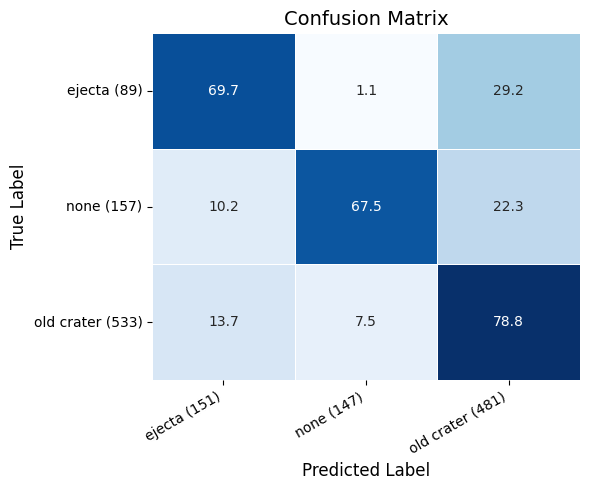

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Row-normalize to percentages
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Build axis tick labels with counts
true_labels = [f"ejecta ({cm[0].sum()})",
               f"none ({cm[1].sum()})",
               f"old crater ({cm[2].sum()})"]

pred_labels = [f"ejecta ({cm[:,0].sum()})",
               f"none ({cm[:,1].sum()})",
               f"old crater ({cm[:,2].sum()})"]

plt.figure(figsize=(6, 5))

ax = sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=pred_labels,
    yticklabels=true_labels,
    cbar=False,
    linewidths=0.5,
    linecolor="white"
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.yticks(rotation=0)
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()


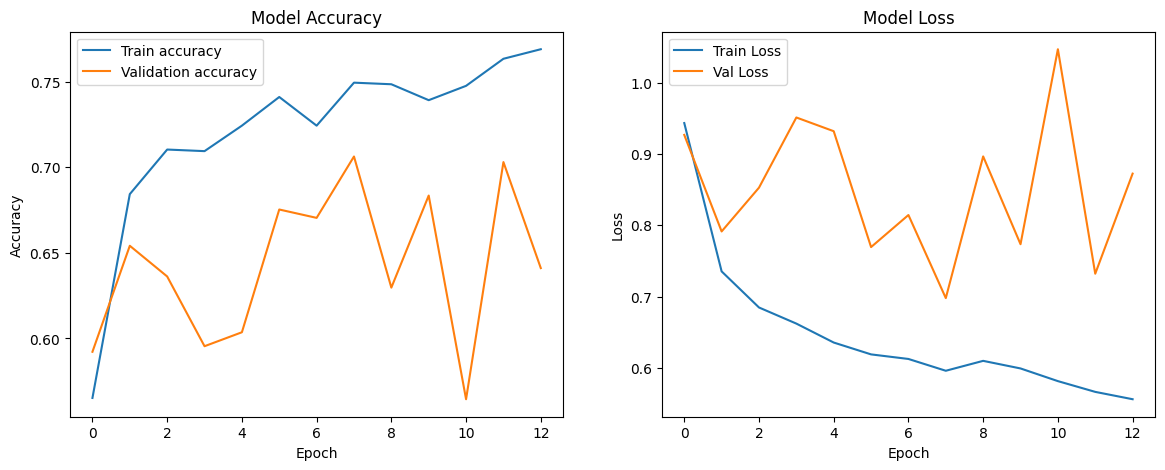

In [11]:
import matplotlib.pyplot as plt

# 'history' is the History object returned by model.fit()

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14,5))

# -------------------------
# Plot 1 — Model Accuracy
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# -------------------------
# Plot 2 — Model Loss
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,606,155 (90.05 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 12,296 (48.04 KB)

In [13]:
print("Image shape:", images[0].shape)
print("Image dtype:", images[0].dtype)
print("Min/max:", images[0].numpy().min(), images[0].numpy().max())


Image shape: (227, 227, 3)
Image dtype: <dtype: 'float32'>
Min/max: -109.68 142.061


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


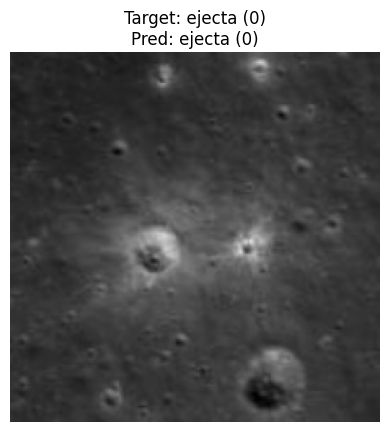

In [14]:
IMAGENET_MEAN_BGR = np.array([103.939, 116.779, 123.68], dtype=np.float32)

target_image_index = 2   # 👈 choose which dataset image (0-based)
k = 0

for images, labels in test_dataset:
    if k == target_image_index:
        img = images[0].numpy().copy()
        true_idx = int(labels[0].numpy())

        preds = model.predict(images)   # batch size = 1
        pred_idx = int(np.argmax(preds[0]))

        # Undo ResNet50 preprocess
        img += IMAGENET_MEAN_BGR
        img = img[..., ::-1]            # BGR → RGB
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.imshow(img)
        plt.title(
            f"Target: {target_names[true_idx]} ({true_idx})\n"
            f"Pred: {target_names[pred_idx]} ({pred_idx})"
        )
        plt.axis("off")
        plt.show()
        break

    k += 1


In [15]:
# Final classification layer (Dense)
final_dense = model.layers[-1]

print(final_dense)


<Dense name=dense, built=True>


In [16]:
kernel, bias = final_dense.get_weights()


In [17]:
class_index = 1

gap_weights = kernel[:, class_index]
print(gap_weights.shape)


(2048,)


In [18]:
print("Min:", gap_weights.min())
print("Max:", gap_weights.max())


Min: -0.10595829
Max: 0.111635506


In [19]:

import matplotlib.cm as cm
import cv2


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Access the specific layers by name from your Sequential model
    #    (These names match the summary image you provided)
    conv_layer = model.get_layer(last_conv_layer_name)  # This is the "resnet50" layer
    gap_layer = model.get_layer("global_average_pooling2d")
    classifier_layer = model.get_layer("dense")

    # 2. Record the forward pass manually
    with tf.GradientTape() as tape:
        # Cast input to float32
        inputs = tf.cast(img_array, tf.float32)
        
        # Pass input through the ResNet50 layer
        conv_output = conv_layer(inputs)
        
        # CRITICAL: We must tell the tape to watch this specific tensor
        # so we can calculate gradients with respect to it later.
        tape.watch(conv_output)
        
        # Pass the output through the remaining layers
        pooled_output = gap_layer(conv_output)
        preds = classifier_layer(pooled_output)
        
        # Determine the top class index if not provided
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        
        # Get the score for the target class
        class_channel = preds[:, pred_index]

    # 3. Compute gradients of the predicted class w.r.t the conv output
    grads = tape.gradient(class_channel, conv_output)

    # 4. Global Average Pooling of the gradients (Standard Grad-CAM logic)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Weight the feature maps
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


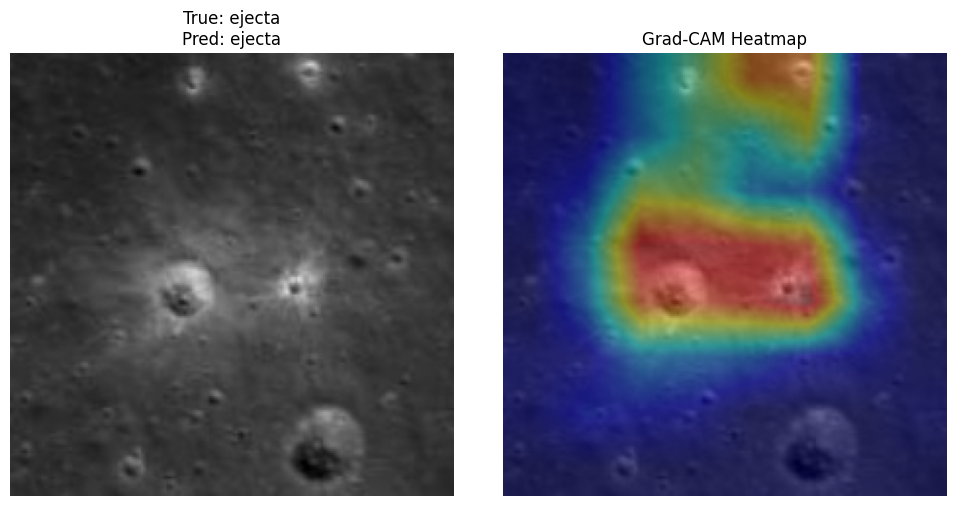

In [20]:
IMAGENET_MEAN_BGR = np.array([103.939, 116.779, 123.68], dtype=np.float32)
target_names = ["ejecta", "none", "oldcrater"] 

# Based on your summary image, the layer before GlobalAveragePooling is named "resnet50"
last_conv_layer_name = "resnet50"

target_image_index = 2 
k = 0

for images, labels in test_dataset:
    if k == target_image_index:
        # --- 1. Prepare Data ---
        # 'images' is a batch. We keep it as a batch for the model, 
        # but take the first one for processing.
        input_tensor = images # Shape (Batch_Size, H, W, 3)
        
        # --- 2. Make Prediction ---
        preds = model.predict(input_tensor)
        pred_idx = int(np.argmax(preds[0]))
        true_idx = int(labels[0].numpy())

        # --- 3. Generate Grad-CAM Heatmap ---
        heatmap = make_gradcam_heatmap(input_tensor, model, last_conv_layer_name, pred_idx)

        # --- 4. Image De-processing (Your original code) ---
        img = images[0].numpy().copy()
        img += IMAGENET_MEAN_BGR
        img = img[..., ::-1] # BGR -> RGB
        img = np.clip(img, 0, 255).astype(np.uint8)

        # --- 5. Superimpose Heatmap on Image ---
        # Resize heatmap to match original image dimensions
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        
        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)
        
        # Use jet colormap
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        # Convert heatmap to RGB (OpenCV uses BGR by default)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Superimpose (0.4 is the heatmap intensity)
        superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

        # --- 6. Plotting ---
        plt.figure(figsize=(10, 5))
        
        # Plot Original
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"True: {target_names[true_idx]}\nPred: {target_names[pred_idx]}")
        plt.axis("off")

        # Plot Grad-CAM
        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        break

    k += 1